In [1]:
import pandas as pd
from binom_mixture_model import BinomialMixture, estimate_clonal_marker_frequency,find_posterior_probs
import numpy as np
import matplotlib.pyplot as plt

cuda is unavailable


In [2]:
def find_X_specific_mutations(mut, count_df_donor0, coverage_df_donor0, count_df_donor1,coverage_df_donor1):

    a1_res = estimate_clonal_marker_frequency(mut+'_a1', count_df_donor0[mut].values, coverage_df_donor0[mut].values)
    a2_res = estimate_clonal_marker_frequency(mut+'_a2', count_df_donor1[mut].values, coverage_df_donor1[mut].values)
   
    
    mut_rate_difference = a1_res['BM_2_theta_1']/a2_res['BM_2_theta_1']
    return a1_res['n_cells'],float(a1_res['BM_2_pi_1']),float(a1_res['BM_2_theta_1']),a2_res['n_cells'], float(a2_res['BM_2_pi_1']), float(a2_res['BM_2_theta_1']), mut_rate_difference

In [3]:
XCI_file = '/home/antonl/projects/XAlgo/PBMC_donor7/vireo_out/donor_ids.tsv'
mito_allele_freq_file = '/home/antonl/projects/TSTAMTAXAFCD/PBMC_donor7/PBMC_donor7_mitochondrial_allele_frequency_all_variants.csv'
coverage_file = '/home/antonl/projects/TSTAMTAXAFCD/PBMC_donor7/PBMC_donor7_mitochondrial_coverage_all_variants.csv'
count_file = '/home/antonl/projects/TSTAMTAXAFCD/PBMC_donor7/PBMC_donor7_mitochondrial_count_all_variants.csv'

In [16]:
metadata_df = pd.read_csv('/home/antonl/notebooks/XAlgo/PBMCs/PBMCs.allruns.barcode_annotation.txt', sep='\t')

In [21]:
metadata_df = metadata_df[metadata_df['donor'] == 'donor7']
metadata_df = metadata_df[metadata_df['QC_status'] == 'QCpass']
metadata_df.index = metadata_df['barcode']

In [4]:
vireo_df = pd.read_csv(XCI_file, sep='\t', index_col=0)
mito_mutations_allele_frequency = pd.read_csv(mito_allele_freq_file, index_col=0)

In [5]:
summary_file = '/home/antonl/projects/TSTAMTAXAFCD/PBMC_donor7/PBMC_donor7_mutation_summary_statistics.csv'

In [268]:
summary_df = pd.read_csv(summary_file, index_col=0)

In [7]:
coverage_df = pd.read_csv(coverage_file, index_col=0)

In [27]:
coverage_df = coverage_df.reindex(metadata_df.index).dropna()

In [8]:
count_df = pd.read_csv(count_file, index_col=0)

In [28]:
count_df = count_df.reindex(metadata_df.index).dropna()

In [925]:
fraction_df = count_df/coverage_df
fraction_df = fraction_df.fillna(0)

In [29]:
count_df_donor0 = count_df.reindex(vireo_df.index[vireo_df['donor_id'] == 'donor0']).dropna()

count_df_donor1 = count_df.reindex(vireo_df.index[vireo_df['donor_id'] == 'donor1']).dropna()

coverage_df_donor0 = coverage_df.reindex(vireo_df.index[vireo_df['donor_id'] == 'donor0']).dropna()

coverage_df_donor1 = coverage_df.reindex(vireo_df.index[vireo_df['donor_id'] == 'donor1']).dropna()

In [38]:
summary_subset_df = summary_df[summary_df['n_cells_conf_detected'] > 0]

In [ ]:
mut_mutation_rate = {}

In [42]:
sum([mut not in mut_mutation_rate for mut in summary_subset_df.index])

4826

In [ ]:

i = 0
for mut in summary_subset_df.index:
    mut_key = 'X'+mut.replace('>','.')
    if mut in mut_mutation_rate:
        i += 1
        if i % 100 == 0:
            print(i)
        continue
    mut_mutation_rate[mut] = find_X_specific_mutations(mut_key, count_df_donor0, coverage_df_donor0, count_df_donor1,coverage_df_donor1)
    i += 1
    if i % 100 == 0:
        print(i)

In [44]:
def make_get_pred_clonal_cells(allele):
    def get_pred_clonal_cells(row):
        if row['p_{}'.format(allele)] < 0.02:
            return 0
        else:
            return row['n_cells_{}'.format(allele)]*row['pi_{}'.format(allele)]
    return get_pred_clonal_cells

def get_clonal_mutations(row):
    if row['p_a1'] < 0.04 and row['p_a2'] > 0.04:
        return 'a2' if row['pred_clonal_cells_a2'] > 0 else 'NA'
    elif row['p_a1'] > 0.04 and row['p_a2'] < 0.04:
        return 'a1' if row['pred_clonal_cells_a1'] > 0 else 'NA'
    else:
        return 'NA'

def find_mutated_cells(row, count_df_donor0, coverage_df_donor0, count_df_donor1,coverage_df_donor1, count_df):
    mut_key = row.name
    mut_key = 'X'+mut_key.replace('>','.')
    allele = row['assigned_clonal_allele']
    if allele == 'a1':
        count_series = count_df_donor0[mut_key]
        coverage_series = coverage_df_donor0[mut_key]
    else:
        count_series = count_df_donor1[mut_key]
        coverage_series = coverage_df_donor1[mut_key]
    res = find_posterior_probs(mut_key, count_series, coverage_series)
    posterior_df = pd.DataFrame(res[0].numpy(), columns=res[1])
    mut_prob = posterior_df.loc[1]
    mut_prob.name = row.name
    mut_prob = mut_prob.reindex(count_df.index).fillna(1e-18)
    return mut_prob

In [289]:
X_specific_mutation_rate_df = pd.DataFrame.from_dict(mut_mutation_rate).T

X_specific_mutation_rate_df.columns = ['n_cells_a1', 'pi_a1', 'p_a1', 'n_cells_a2','pi_a2','p_a2', 'ratio']

X_specific_mutation_rate_filtered_df = X_specific_mutation_rate_df[(X_specific_mutation_rate_df['p_a1'] > 0.04) | (X_specific_mutation_rate_df['p_a2'] > 0.04)]

X_specific_mutation_rate_filtered_df['pred_clonal_cells_a1'] = X_specific_mutation_rate_filtered_df.apply(make_get_pred_clonal_cells('a1'), axis=1)
X_specific_mutation_rate_filtered_df['pred_clonal_cells_a2'] = X_specific_mutation_rate_filtered_df.apply(make_get_pred_clonal_cells('a2'), axis=1)

X_specific_mutation_rate_filtered_df['assigned_clonal_allele'] = X_specific_mutation_rate_filtered_df.apply(get_clonal_mutations, axis=1)

X_specific_mutation_rate_more_filtered_df = X_specific_mutation_rate_filtered_df[X_specific_mutation_rate_filtered_df['assigned_clonal_allele'] != 'NA']

X_specific_mutation_rate_more_filtered_df['ratio_log10'] = np.log10(X_specific_mutation_rate_more_filtered_df['ratio']+1e-6)

/home/nbserver/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/nbserver/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nbserver/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [1312]:
X_specific_mutation_rate_filtered_df.reindex(summary_cov_over_20_filtered_df.index).groupby('assigned_clonal_allele').count()

,n_cells_a1,pi_a1,p_a1,n_cells_a2,pi_a2,p_a2,ratio,pred_clonal_cells_a1,pred_clonal_cells_a2
assigned_clonal_allele,,,,,,,,,
NA,209,209,209,209,209,209,209,209,209
a1,365,365,365,365,365,365,365,365,365
a2,156,156,156,156,156,156,156,156,156


In [295]:
X_specific_mutation_rate_more_filtered_df = X_specific_mutation_rate_more_filtered_df.join(summary_df)

In [297]:
X_specific_mutation_final_cov_over_50_filtered_df = X_specific_mutation_rate_more_filtered_df[(X_specific_mutation_rate_more_filtered_df['vmr'] > 0.01)&(X_specific_mutation_rate_more_filtered_df['strand_correlation']>0.65)&(X_specific_mutation_rate_more_filtered_df['mean_coverage']>50)]

In [291]:
X_specific_mutation_rate_df_both_alleles = X_specific_mutation_rate_df[X_specific_mutation_rate_df.apply(lambda row: row['p_a1'] > 0.04 and row['p_a2'] > 0.04, axis=1)]

In [47]:
import seaborn as sns

In [442]:
X_specific_mutation_rate_df['p_a1_log10'] = np.log10(X_specific_mutation_rate_df['p_a1'])
X_specific_mutation_rate_df['p_a2_log10'] = np.log10(X_specific_mutation_rate_df['p_a2'])

/home/nbserver/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [56]:
mut_prob_dict = {}

In [ ]:
i = 0
for mut, row in X_specific_mutation_rate_more_filtered_df.iterrows():
    if mut in mut_prob_dict:
        i += 1
        if i % 100 == 0:
            print(i)
        continue
    mut_res = find_mutated_cells(row, count_df_donor0, coverage_df_donor0, count_df_donor1,coverage_df_donor1, count_df)
    mut_prob_dict[mut] = mut_res
    i += 1
    if i % 100 == 0:
        print(i)

In [159]:
mut_prob_df = pd.DataFrame(mut_prob_dict).reindex(X_specific_mutation_rate_more_filtered_df.index, axis=1)

In [223]:
mut_prob_filtered_df =  mut_prob_df.reindex(mut_prob_df.columns[(mut_prob_df > 0.1).sum() > 0], axis=1)

In [226]:
X_specific_mutation_final_df = X_specific_mutation_rate_more_filtered_df.reindex(mut_prob_filtered_df.columns).join(summary_df)

In [259]:
X_specific_mutation_final_cov_over_50_filtered_df = X_specific_mutation_final_cov_over_50_df[(X_specific_mutation_final_cov_over_50_df['vmr'] > 0.01)&(X_specific_mutation_final_cov_over_50_df['strand_correlation']>0.65)]

In [326]:
filtered_muts = X_specific_mutation_rate_more_filtered_df.index[X_specific_mutation_rate_more_filtered_df.apply(lambda row: (row['p_a1'] > 1e-5)&(row['p_a2']> 1e-5), axis=1)]

In [328]:
muts_to_drop = X_specific_mutation_rate_more_filtered_df.index[X_specific_mutation_rate_more_filtered_df.apply(lambda row: (row['p_a1'] <= 1e-5)|(row['p_a2'] <= 1e-5), axis=1)]

In [1288]:
len(muts_to_drop)

84

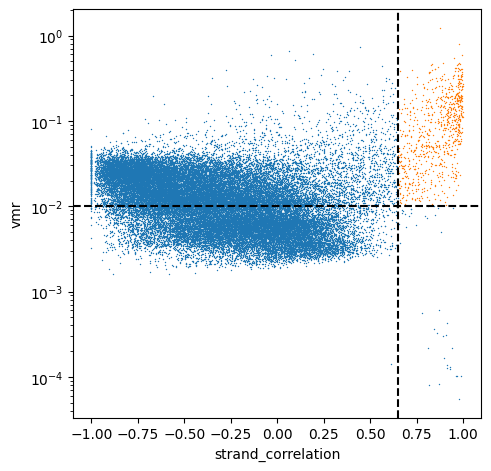

In [802]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(y='vmr', x='strand_correlation', data=summary_cov_over_20_df.drop(summary_cov_over_20_filtered_df.index),ax=ax, s=1, linewidth=0)
sns.scatterplot(y='vmr', x='strand_correlation', data=summary_cov_over_20_filtered_df, ax=ax, s=1, linewidth=0)
ax.axvline(0.65, linestyle='dashed', color='black')
ax.axhline(1e-2, linestyle='dashed', color='black')
ax.set_yscale('log')
ax.set_box_aspect(1)
plt.tight_layout()
plt.savefig('figures/Fig2G.pdf')

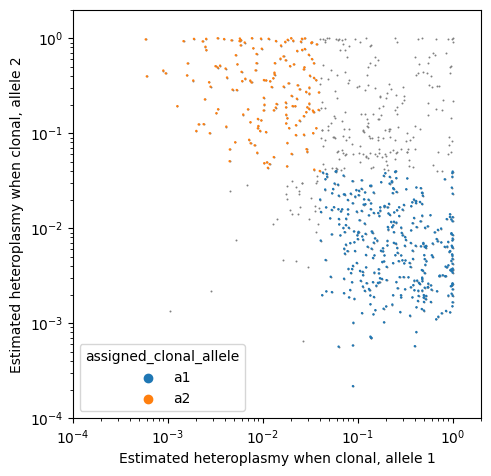

In [803]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(x='p_a1', y='p_a2', s=2, data=X_specific_mutation_rate_df.drop(muts_to_drop, errors='ignore').reindex(summary_cov_over_20_filtered_df.index),color='grey',ax=ax, linewidth=0)
#sns.scatterplot(x='p_a1', y='p_a2', s=1, data=X_specific_mutation_rate_df_both_alleles,color='grey',ax=ax)
sns.scatterplot(x='p_a1', y='p_a2', s=3, palette={'a1':'C0', 'a2':'C1', 'NA': 'white'},hue='assigned_clonal_allele', data=X_specific_mutation_rate_more_filtered_df.reindex(filtered_muts).reindex(summary_cov_over_20_filtered_df.index), linewidth=0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Estimated heteroplasmy when clonal, allele 1')
ax.set_ylabel('Estimated heteroplasmy when clonal, allele 2')
ax.set_xlim((1e-4,2))
ax.set_ylim((1e-4,2))
ax.set_box_aspect(1)
plt.tight_layout()
plt.savefig('figures/Fig2H.pdf.pdf')
plt.show()

In [1412]:
result_bad_muts_df = X_specific_mutation_rate_filtered_df.reindex(summary_cov_over_20_filtered_df.index).drop(clonal_muts)

In [1415]:
result_bad_muts_df = result_bad_muts_df.join(summary_cov_over_20_df).dropna()

In [ ]:
def find_mutated_cells_a2(row, count_df_donor1,coverage_df_donor1, count_df):
    mut_key = row.name
    mut_key = 'X'+mut_key.replace('>','.')
    
    count_series = count_df_donor1[mut_key]
    coverage_series = coverage_df_donor1[mut_key]
    
    res = find_posterior_probs(mut_key, count_series, coverage_series)
    posterior_df = pd.DataFrame(res[0].numpy(), columns=res[1])
    mut_prob = posterior_df.loc[1]
    mut_prob.name = row.name
    mut_prob = mut_prob.reindex(count_df.index).fillna(1e-18)
    return mut_prob

In [471]:
def find_mutated_cells_no_allele(row, count_df_donorX, coverage_df_donorX, count_df):
    mut_key = row.name
    mut_key = 'X'+mut_key.replace('>','.')
    
    count_series = count_df_donorX[mut_key]
    coverage_series = coverage_df_donorX[mut_key]
    try: 
        res = find_posterior_probs(mut_key, count_series, coverage_series)
    except:
        
    posterior_df = pd.DataFrame(res[0].numpy(), columns=res[1])
    mut_prob = posterior_df.loc[1]
    mut_prob.name = row.name
    mut_prob = mut_prob.reindex(count_df.index).fillna(1e-18)
    return mut_prob

In [1102]:
def likelihood_test_no_allele(mut, count_df_donorX, coverage_df_donorX, other_df, allele):
    p_h_1 = other_df.loc[mut]['p_{}'.format(allele)]
    mut_key = 'X'+mut.replace('>','.')
    count_array = count_df_donorX[mut_key].values
    coverage_array = coverage_df_donorX[mut_key].values
    H_0 = binom.logpmf(count_array, coverage_array, p=0.01)
    H_1 = binom.logpmf(count_array, coverage_array, p=p_h_1)
    pvalue = 1 - chi2(1).cdf(-2*(H_0-H_1))
    pvalue_series = pd.Series(pvalue, index=count_df_donorX.index)
    sig_series = pvalue_series<0.05
    return sig_series

In [483]:
mut_prob_a1 = {}
mut_prob_a2 = {}
i = 0
for mut, row in result_bad_muts_df.iterrows():
    if mut in muts_to_drop:
        continue
    mut_res_a1 = find_mutated_cells_no_allele(row, count_df_donor0, coverage_df_donor0, count_df)
    mut_prob_a1[mut] = mut_res_a1
    
    mut_res_a2 = find_mutated_cells_no_allele(row, count_df_donor1, coverage_df_donor1, count_df)
    mut_prob_a2[mut] = mut_res_a2
    
    i += 1
    if i % 100 == 0:
        print(i)

100
200


In [ ]:
X_specific_mutation_rate_df

In [1103]:
htest_res_a1 = {}
htest_res_a2 = {}
i = 0
for mut in result_bad_muts_df.index:
    if mut in muts_to_drop:
        continue
    mut_res_a1 = likelihood_test_no_allele(mut, count_df_donor0, coverage_df_donor0, X_specific_mutation_rate_df, 'a1')
    htest_res_a1[mut] = mut_res_a1
    
    mut_res_a2 = likelihood_test_no_allele(mut, count_df_donor1, coverage_df_donor1, X_specific_mutation_rate_df, 'a2')
    htest_res_a2[mut] = mut_res_a2
    
    i += 1
    if i % 100 == 0:
        print(i)

100
200


In [1125]:
htest_bad_muts_a1_df = pd.DataFrame(htest_res_a1)
htest_bad_muts_a2_df = pd.DataFrame(htest_res_a2)

In [1127]:
mut_prob_bad_muts_a1_df = pd.DataFrame(mut_prob_a1)
mut_prob_bad_muts_a2_df = pd.DataFrame(mut_prob_a2)

In [1132]:
mut_calling_bad_muts_a1_df = (mut_prob_bad_muts_a1_df>0.95).reindex(htest_bad_muts_a1_df.index)&htest_bad_muts_a1_df

In [1133]:
mut_calling_bad_muts_a2_df = (mut_prob_bad_muts_a2_df>0.95).reindex(htest_bad_muts_a2_df.index)&htest_bad_muts_a2_df



In [1172]:
mut_calling_bad_muts_all_df = mut_calling_bad_muts_a1_df.append(mut_calling_bad_muts_a2_df)

In [1182]:
mut_calling_bad_muts_all_under_500_df = mut_calling_bad_muts_all_df.reindex(mut_calling_bad_muts_all_df.columns[mut_calling_bad_muts_all_df.sum() < 500],axis=1)

In [1183]:
mut_calling_bad_muts_all_under_500_df.to_csv('mut_calling_bad_muts_all_under_500.csv')

In [1135]:
cell_count_a1 = mut_calling_bad_muts_a1_df.sum()

In [1136]:
cell_count_a2 = mut_calling_bad_muts_a2_df.sum()

In [1137]:
bad_muts_cell_count_df = pd.DataFrame([cell_count_a1, cell_count_a2], index=['a1','a2']).T

In [1138]:
bad_muts_cell_count_df['fraction_a1'] = bad_muts_cell_count_df['a1']/(bad_muts_cell_count_df['a1']+bad_muts_cell_count_df['a2'])

In [1139]:
bad_muts_cell_count_df['total'] = (bad_muts_cell_count_df['a1']+bad_muts_cell_count_df['a2'])

In [1387]:
OE_2 = (175+91)/((binom.pmf(0, 2, p=a1_fraction)*(175+91+82))+(binom.pmf(2, 2, p=a1_fraction)*(175+91+82)))

In [1388]:
OE_3 = (36+8)/((binom.pmf(0, 3, p=a1_fraction)*(36+8+54))+(binom.pmf(3, 3, p=a1_fraction)*(36+8+54)))

In [1389]:
OE_4 = (11+3)/((binom.pmf(0, 4, p=a1_fraction)*(11+3+18))+(binom.pmf(4, 4, p=a1_fraction)*(11+3+18)))

In [1390]:
OE_5 = 10/((binom.pmf(5, 5, p=a1_fraction)*(16)))

In [1391]:
OE_6 = (3)/((binom.pmf(6, 6, p=a1_fraction)*(3+7))+(binom.pmf(0, 6, p=a1_fraction)*(3+7)))

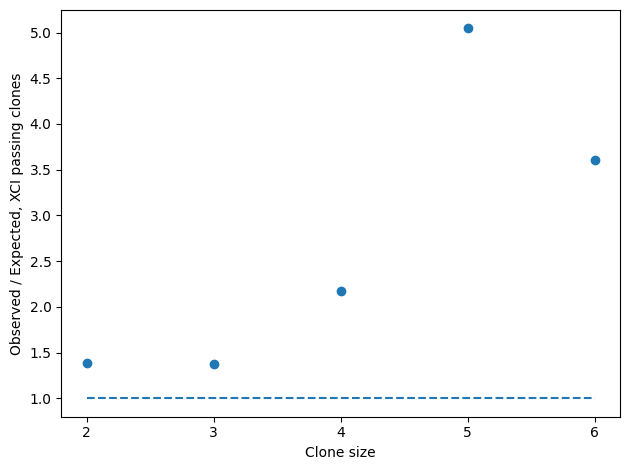

In [1405]:
plt.plot(np.arange(2,7), [OE_2, OE_3, OE_4, OE_5, OE_6], 'o')
plt.hlines(1, 2,6, linestyle='dashed')
plt.xticks(np.arange(2,7))
plt.xlabel('Clone size')
plt.ylabel('Observed / Expected, XCI passing clones')
plt.tight_layout()
plt.show()

In [1140]:
vireo_filtered_df = vireo_df.reindex(mut_prob_df.index)

In [1141]:
vireo_filtered_df.groupby('donor_id').count()

,prob_max,prob_doublet,n_vars,best_singlet,best_doublet,doublet_logLikRatio
donor_id,,,,,,
donor0,1985,1985,1985,1985,1985,1985
donor1,1029,1029,1029,1029,1029,1029
unassigned,4,4,4,4,4,4


In [1142]:
a1_fraction = 1985/(1985+1029)

In [1325]:
X_specific_mutation_super_final_df = X_specific_mutation_rate_more_filtered_df.reindex(filtered_muts).reindex(summary_cov_over_20_filtered_df.index).dropna()

In [1326]:
n_clonal_cells = (mut_prob_df.reindex(X_specific_mutation_super_final_df.index, axis=1) > 0.95).sum()
n_clonal_cells.name = 'n_clonal_cells'

In [1330]:
X_specific_mutation_super_final_df = X_specific_mutation_super_final_df.join(n_clonal_cells)

In [1331]:
X_specific_mutation_super_final_df = X_specific_mutation_super_final_df[X_specific_mutation_super_final_df['n_clonal_cells'] > 0]

In [1422]:
X_specific_mutation_super_final_df = X_specific_mutation_super_final_df.drop('8167T>C')

In [797]:
clonal_muts_value_counts = X_specific_mutation_super_final_df['n_clonal_cells'].value_counts().sort_index()

In [1045]:
PBMC_annotation_df = pd.read_csv('PBMCs.allruns.barcode_annotation.txt', sep='\t', index_col=0).dropna()

In [1046]:
PBMC_annotation_df = PBMC_annotation_df[PBMC_annotation_df['donor'] == 'donor7']
PBMC_annotation_df = PBMC_annotation_df[PBMC_annotation_df['QC_status'] == 'QCpass']
PBMC_annotation_df.index = PBMC_annotation_df['barcode']

In [1047]:
mut_prob_clonal_df = mut_prob_filtered_df.reindex(X_specific_mutation_super_final_df.index, axis=1)

In [1049]:
mut_counts_cells = mutation_call_df.sum(axis=1)
mut_counts_cells.name = 'mut_counts_cells'

In [1050]:
mutation_call_df.to_csv('Donor7_clonal_mt_mutations.csv')

In [1051]:
PBMC_annotation_df = PBMC_annotation_df.join(mut_counts_cells).fillna(0)

In [1052]:
PBMC_cell_annotation_count = PBMC_annotation_df.groupby('celltype_lvl2_inex_10khvg_reads_res08_new').count()['run']
PBMC_cell_annotation_count.name = 'PBMC_cell_annotation_count'

In [1053]:
PBMC_mt_muts_count_df = PBMC_annotation_df.groupby('celltype_lvl2_inex_10khvg_reads_res08_new').apply(lambda df: (df['mut_counts_cells'] > 0).sum()).reset_index()
PBMC_mt_muts_count_df.columns = ['cell_annotation', 'count']
PBMC_mt_muts_count_df.index = PBMC_mt_muts_count_df['cell_annotation']

In [1054]:
PBMC_mt_muts_count_df = PBMC_mt_muts_count_df.join(PBMC_cell_annotation_count)

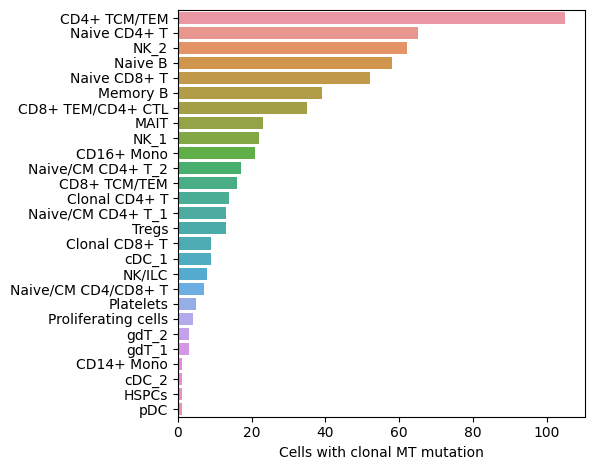

In [1124]:
g = sns.barplot(y='cell_annotation', x='count', data=PBMC_mt_muts_count_df.sort_values('count', ascending=False))
g.set_box_aspect(1)
g.set_ylabel('')
g.set_xlabel('Cells with clonal MT mutation')
plt.tight_layout()
plt.savefig('figures/Supp_Fig_5A.pdf')

In [1056]:
PBMC_mt_muts_count_df['percent_with_mutation'] = 100*(PBMC_mt_muts_count_df['count']/PBMC_mt_muts_count_df['PBMC_cell_annotation_count'])

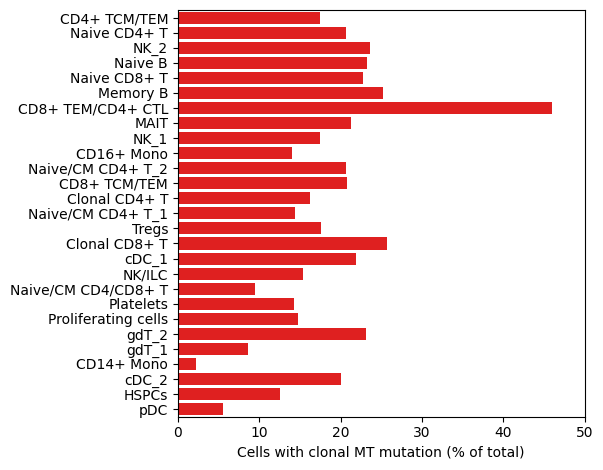

In [1440]:
g = sns.barplot(y='cell_annotation', x='percent_with_mutation', data=PBMC_mt_muts_count_df.sort_values('count', ascending=False), color='red')
g.set_box_aspect(1)
g.set_ylabel('')
g.set_xlabel('Cells with clonal MT mutation (% of total)')
g.set_xlim((0,50))
g.set_box_aspect(1)
plt.tight_layout()
plt.savefig('figures/Fig2I.pdf')

In [944]:
from scipy.stats import chi2

In [1020]:
def likelihood_ratio_test(mut, count_df, coverage_df, other_df):
    p_h_1 = other_df.loc[mut]['p_{}'.format(other_df.loc[mut]['assigned_clonal_allele'])]
    mut_key = 'X'+mut.replace('>','.')
    count_array = count_df[mut_key].values
    coverage_array = coverage_df[mut_key].values
    H_0 = binom.logpmf(count_array, coverage_array, p=0.01)
    H_1 = binom.logpmf(count_array, coverage_array, p=p_h_1)
    pvalue = 1 - chi2(1).cdf(-2*(H_0-H_1))
    pvalue_series = pd.Series(pvalue, index=count_df.index)
    sig_series = pvalue_series<0.05
    return sig_series

In [1023]:
sig_list = {}
for mut in X_specific_mutation_rate_more_filtered_df.index:
    sig_list[mut] = likelihood_ratio_test(mut,count_df, coverage_df,X_specific_mutation_rate_more_filtered_df)

In [1027]:
sig_df = pd.DataFrame(sig_list)

In [1044]:
mutation_call_df = ((mut_prob_df > 0.95)&sig_df).reindex(X_specific_mutation_super_final_df.index, axis=1)

In [1010]:
count_array = count.values

coverage_array = coverage.values

H_0 = binom.logpmf(count_array, coverage_array, p=0.01)

H_1 = binom.logpmf(count_array, coverage_array, p=0.296919)


pvalue = 1 - chi2(1).cdf(-2*(H_0-H_1))

In [1011]:
pvalue_series = pd.Series(pvalue, index=count.index)
pvalue_series[pvalue_series<0.05].shape

(11,)

In [1206]:
def _shannon_entropy(counts):
        """Normalized shannon entropy according to
        https://math.stackexchange.com/a/945172
        """
        freqs = counts / np.sum(counts)
        np.testing.assert_almost_equal(np.sum(freqs), 1)
        if len(freqs) == 1:
            # the formula below is not defined for n==1
            return 0
        else:
            return -np.sum((freqs * np.log(freqs)) / np.log([len(freqs)]))

In [1209]:
def compute_alpha_diversity(cell_cluster_df, mutation_call_df):
    mutation_call_subset_df = mutation_call_df.reindex(cell_cluster_df.index).dropna()
    mut_counts = mutation_call_subset_df.sum()[mutation_call_subset_df.sum()>0]
    return mut_counts.shape[0], _shannon_entropy(mut_counts.astype(int).values)

In [1210]:
mutations_in_cluster_dict = {}
alpha_diversity_in_cluster = {}
for cell_cluster, cell_cluster_df in PBMC_annotation_df.groupby('celltype_lvl2_inex_10khvg_reads_res08_new'):
    mutations_in_cluster, alpha_diversity = compute_alpha_diversity(cell_cluster_df, mutation_call_df)
    mutations_in_cluster_dict[cell_cluster] = mutations_in_cluster
    alpha_diversity_in_cluster[cell_cluster] = alpha_diversity

In [1237]:
mutations_in_cluster_and_alpha_diversity_df = pd.DataFrame([mutations_in_cluster_dict,alpha_diversity_in_cluster], index=['Mutations in cluster', 'Alpha diversity']).T

In [1238]:
mutations_in_cluster_and_alpha_diversity_df['Mutations in cluster (normalized)'] = mutations_in_cluster_and_alpha_diversity_df['Mutations in cluster']/PBMC_annotation_df.groupby('celltype_lvl2_inex_10khvg_reads_res08_new').count()['mut_counts_cells']

In [1239]:
mutations_in_cluster_and_alpha_diversity_df = mutations_in_cluster_and_alpha_diversity_df.reset_index()

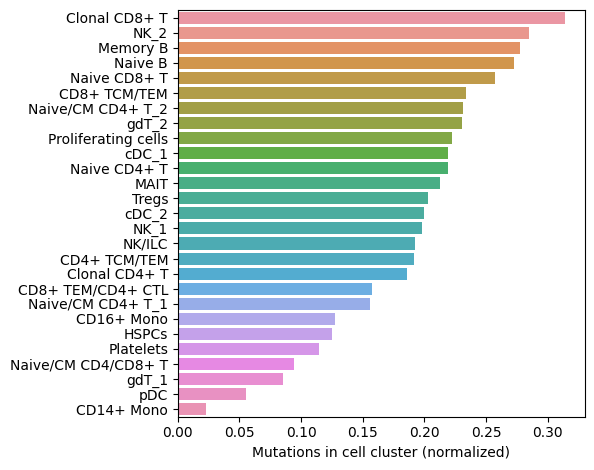

In [1248]:
g = sns.barplot(y='index',x='Mutations in cluster (normalized)', data = mutations_in_cluster_and_alpha_diversity_df.sort_values('Mutations in cluster (normalized)', ascending=False))
g.set_ylabel('')
g.set_xlabel('Mutations in cell cluster (normalized)')
g.set_box_aspect(1)
plt.tight_layout()
plt.savefig('figures/Supp_Fig_5B.pdf')

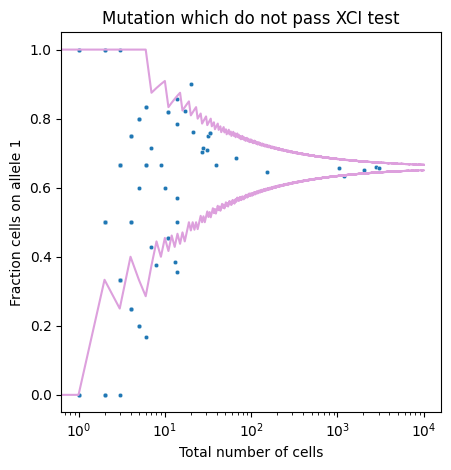

In [1159]:
fig, ax = plt.subplots(1,1)
ax.plot(binom.ppf(0.05, np.arange(1,10000), p=a1_fraction)/np.arange(1,10000), color='plum')
ax.plot(binom.ppf(0.95, np.arange(1,10000), p=a1_fraction)/np.arange(1,10000), color='plum')
sns.scatterplot(x='total', y='fraction_a1', data=bad_muts_cell_count_df.reindex(bad_mut_subset), s=10, ax=ax)
#g.axhline(a1_fraction, linestyle='dashed', color='black')
ax.set_xscale('log')
ax.set_box_aspect(1)
ax.set_ylabel('Fraction cells on allele 1')
ax.set_xlabel('Total number of cells')
ax.set_title('Mutation which do not pass XCI test')
plt.tight_layout()
plt.savefig('figures/Supp_Fig_4.pdf')
plt.show()

In [1154]:
lower_percentile = binom.ppf(0.025, np.arange(1,10000), p=a1_fraction)
upper_percentile = binom.ppf(0.975, np.arange(1,10000), p=a1_fraction)

In [1155]:
i = 0
muts_outside_percentiles = []
for mut, row in bad_muts_cell_count_df.reindex(bad_mut_subset).iterrows():
    if (row['a1'] > lower_percentile[int(row['total']-1)]) & (row['a1'] < upper_percentile[int(row['total']-1)]):
        i += 1
    else:
        muts_outside_percentiles.append(mut)

In [1156]:
bad_muts_cell_count_df.reindex(bad_mut_subset)[bad_muts_cell_count_df.reindex(bad_mut_subset)['total'] > 1]

,a1,a2,fraction_a1,total
709G>A,1,5,0.166667,6
877G>A,1,2,0.333333,3
988G>A,1,1,0.500000,2
1289G>A,4,2,0.666667,6
1419G>A,1,1,0.500000,2
...,...,...,...,...
13710A>T,683,358,0.656100,1041
14292C>T,1,1,0.500000,2
14323G>T,3,2,0.600000,5
14768A>T,5,6,0.454545,11


In [1157]:
len(muts_outside_percentiles)

31

In [540]:
from scipy.stats import binom

In [396]:
clonal_muts = X_specific_mutation_rate_more_filtered_df.reindex(filtered_muts).reindex(summary_cov_over_20_filtered_df.index).dropna().index

In [383]:
mut_prob_test_df = mut_prob_df.T.reindex(filtered_muts).reindex(summary_cov_over_20_filtered_df.index).dropna() > 0.1

In [342]:
summary_cov_over_20_df = summary_df[(summary_df['mean_coverage'] > 20)]

In [343]:
summary_cov_over_20_filtered_df = summary_cov_over_20_df[(summary_cov_over_20_df['vmr'] > 0.01)&(summary_cov_over_20_df['strand_correlation']>0.65)]

In [234]:
clonal_cells_series = (mut_prob_filtered_df>0.1).sum()
clonal_cells_series.name = 'n_clonal_cells'

In [236]:
X_specific_mutation_final_df = X_specific_mutation_final_df.join(clonal_cells_series)

In [248]:
X_specific_mutation_final_cov_over_50_df = X_specific_mutation_final_df[(X_specific_mutation_final_df['mean_coverage'] > 50)]

In [206]:
cells = mut_prob_filtered_df.index[mut_prob_filtered_df['1323G>A'] > 0.1]